In [1]:
import autograd.numpy as np 
from autograd import grad, elementwise_grad, jacobian, make_jvp 
from autograd.scipy.special import erf

import GPy
from GPy.kern import Kern
from GPy.core.parameterization.param import Param

import matplotlib.pyplot as plt

## Loopy Implementations used to test correctness

In [2]:
def hq_old(tmat1, tmat2, lq, bvec, svec, debug=False):
    
    n1, d = tmat1.shape
    n2, d = tmat2.shape
    
    out = np.zeros((n1 * d, n2 * d))
    
    for d1 in range(d):
        
        bd1 = bvec[d1]
        vd1 = bd1 * lq * 0.5
        td1 = tmat1[:,d1]
        sd1 = svec[d1]
        
        fac = np.exp(vd1**2 - bd1 * td1[..., None]) 
        
        erf_minus = erf( td1[..., None] / lq - vd1 ) +  erf( vd1 )
        for d2 in range(d):
            bd2 = bvec[d2]
            td2 = tmat2[:,d2]
            sd2 = svec[d2]
            
            fac_ = fac / (bd1 + bd2)
            
            delta = (td1[...,None] - td2)
            erf_plus = erf(  delta / lq - vd1 ) +  erf( td2[None, ...] / lq + vd1 )
            
            
            erf_minus_ = np.dot(np.exp(-bd2 * td2[..., None]), erf_minus.reshape(1, -1) ).T


            
            all_terms = fac_.reshape(-1,1) * (np.exp(bd1 * td2[None, ...]) * erf_plus - erf_minus_)
            if d1 == d2 and debug:
                print(np.diag(all_terms))

            out[n1*d1:n1*(d1 +1), n2*d2:n2*(d2 +1)] = sd1 * sd2 * all_terms
    return out


In [3]:
def hq_individual(t1, t2, lq, bd1, vd1, bd2):
    fac = np.exp(vd1**2 - bd1 * t1) / (bd1 + bd2)
    erf_plus = np.exp(bd1 * t2) * ( erf((t1-t2)/lq - vd1 ) + erf(t2/lq + vd1 ) )

    erf_minus = np.exp(-bd2 * t2) * ( erf(t1/lq - vd1) + erf(vd1) )

    all_terms = fac * ( erf_plus - erf_minus  ) 
    return all_terms

def hq_test(tmat1, tmat2, lq, bvec, svec, debug=False):
    
    n1, d = tmat1.shape
    n2, d = tmat2.shape
    
    out = np.zeros((n1 * d, n2 * d))
    
    for d1 in range(d):
        
        bd1 = bvec[d1]
        vd1 = bd1 * lq * 0.5
        td1 = tmat1[:,d1]
        sd1 = svec[d1]
        

        for d2 in range(d):
            bd2 = bvec[d2]
            td2 = tmat2[:,d2]
            sd2 = svec[d2]
            
            for i, t1 in enumerate(td1):
                for j, t2 in enumerate(td2):
                    all_terms = hq_individual(t1, t2, lq, bd1, vd1, bd2)
                    out[i * ( d1 + 1 ), j * (d2 + 1)] = sd1 * sd2 * all_terms
    return out


def hq_test2(tmat1, tmat2, lq, bvec, svec, debug=False):
    
    n1, d = tmat1.shape
    n2, d = tmat2.shape
    
    out = np.zeros((n1 * d, n2 * d))
    
    for d1 in range(d):
        
        bd1 = bvec[d1]
        vd1 = bd1 * lq * 0.5
        td1 = tmat1[:,d1]
        sd1 = svec[d1]
        

        for d2 in range(d):
            bd2 = bvec[d2]
            td2 = tmat2[:,d2]
            sd2 = svec[d2]
            
            for i, t1 in enumerate(td1):
                for j, t2 in enumerate(td2):
                    all_terms = hq_individual(t1, t2, lq, bd1, vd1, bd2) + hq_individual(t2, t1, lq, bd1, vd1, bd2)

                    out[i * ( d1 + 1 ), j * (d2 + 1)] = sd1 * sd2 * all_terms
    return out

## Vectorised Kernel And Gradients

In [6]:
def hq(tmat1, tmat2, lq, bvec, svec, debug=False):
    
    n1, d = tmat1.shape
    n2, d = tmat2.shape
    
    out = None
    
    for d1 in range(d):
        bd1 = bvec[d1]
        vd1 = bd1 * lq * 0.5
        td1 = tmat1[:,d1]
        sd1 = svec[d1]
        
        fac = np.exp(vd1**2 - bd1 * td1[...,None]) 
        
        erf_minus = erf( td1[..., None] / lq - vd1 ) +  erf( vd1 )
        for d2 in range(d):
            bd2 = bvec[d2]
            td2 = tmat2[:,d2]
            sd2 = svec[d2]
            
            fac_ = fac / (bd1 + bd2)
            
            delta = (td1[...,None] - td2)
            erf_plus = erf(  delta / lq - vd1 ) +  erf( td2[None, ...] / lq + vd1 )
            
            
            erf_minus_ = np.dot(np.exp(-bd2 * td2[..., None]), erf_minus.reshape(1, -1) ).T
            
            all_terms = fac_.reshape(-1,1) * (np.exp(bd1 * td2[None, ...]) * erf_plus - erf_minus_)
            
            
            if out is None:
                out = (sd1 * sd2 * all_terms)[None, ...]
            else:
                out = np.concatenate((out, (sd1 * sd2 * all_terms)[None,...] ), axis=0)
    out = out.reshape(d,d,n1, n2)
    return np.transpose(out, (0,2,1,3)).reshape(n1 *d , n2 * d)



def k_f(tmat1, tmat2, lvec, bvec, Smat, debug=False,hq=hq):
    q = lvec.shape[0]
    n1, d = tmat1.shape
    n2, d = tmat2.shape
    
    kf = np.zeros((n1 * d, n2 * d))
    
    for i_q in range(q):
        h_q1 = hq(tmat1, tmat2, lvec[i_q], bvec, Smat[i_q], False)
        h_q2 = hq(tmat2, tmat1, lvec[i_q], bvec, Smat[i_q], False)
        
        if debug:
        
            htest = hq_old(tmat1, tmat2, lvec[i_q], bvec, Smat[i_q])
            print((htest ==h_q1).all())
            htest = hq_old(tmat2, tmat1, lvec[i_q], bvec, Smat[i_q])
            print((htest ==h_q2).all())
            plt.imshow(h_q1 + h_q2.T  )
            plt.show()
                
        svec = Smat[i_q]
       
        kf += 0.5 * lvec[i_q] * np.sqrt(np.pi) * ( h_q1 + h_q2.T  )
        
    return kf


def grad_kf(tmat1, tmat2, lvec, bvec, Smat):
    
    
    gradient_funcs = [jacobian(k_f, pi) for pi in (2,3,4)]
    gradients = [gradient(tmat1,tmat2, lvec, bvec, Smat) for gradient in gradient_funcs]
    return gradients

True
True


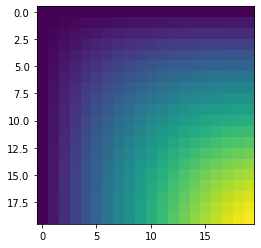

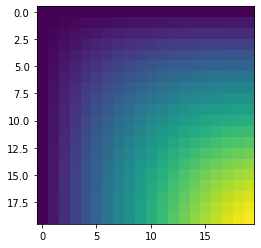

True


In [8]:
test = True
if test:
    q, d = 1, 1
    n = 20

    lvec2 = np.ones(q)
    bvec2 = np.ones(d)
    Smat2 = np.ones((q, d))


    t12 = np.linspace(0,1, n).repeat(d).reshape(n,d)

    t22 =  np.linspace(0,1, n-1).repeat(d).reshape(n-1,d)
    kek = k_f( t12,  t12, lvec2, bvec2, Smat2, debug=True) 

    plt.imshow(kek)
    plt.show()
    print((k_f(t12,t22, lvec2, bvec2, Smat2) == k_f(t12,t22, lvec2, bvec2, Smat2, hq=hq_old)).all())

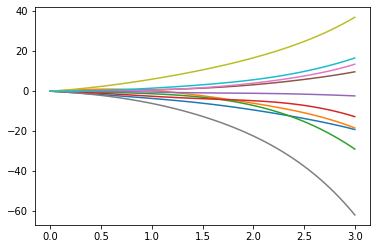

In [55]:
q, d = 1,1
lvec = 0.00001*np.ones(q)
bvec = -1 * np.ones(d)
Smat = 0.0001 * np.ones((q, d))

t1 = np.linspace(0,3, 100).reshape(-1,1)

kn = k_f(t1, t1, np.array([1.34]), np.array([-0.99]), np.array([[2.34]]))

guys = np.random.multivariate_normal(np.zeros(kn.shape[0]), kn, 10)
guys.shape
[plt.plot(t1, guy) for guy in guys];

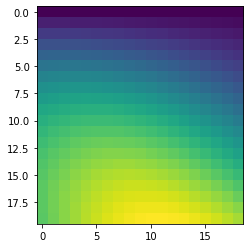

In [10]:
def k_yd_fq(tmat1, tmat2, lq, bvec, Smat, debug=False,hq=hq):
    d = bvec.shape[0]
    out = np.zeros((d * tmat1.shape[0], tmat2.shape[0]))
    for d1 in range(d):
        bd1 = bvec[d1]
        vd1 = bd1 * lq * 0.5
        td1 = tmat1[:,d1]
        td2 = tmat2[:,d1]
        sd1 = Smat[d1]
        
        
        
        delta = (td1[...,None] - td2)
        
        fac = np.exp(vd1**2 - bd1 * delta) 
        
        erf_plus = erf(  delta / lq - vd1 ) +  erf( td2[None, ...] / lq + vd1 )
        out[d1 * tmat1.shape[0]: (d1 + 1) * tmat1.shape[0],:] = 0.5 * np.sqrt(np.pi) * lq * Smat[d1]  * fac * erf_plus
    return out


kfy = k_yd_fq(t12,t22, lvec2[0], bvec2, Smat2)
plt.imshow(kfy)
plt.show()

In [11]:
def diag_hq(tmat, lq, bvec, svec):
    
    n, d = tmat.shape
    
    out = None
    
    for d1 in range(d):
        bd = bvec[d1]
        vd =  bd * lq * 0.5
        td = tmat[:,d1]
        sd = svec[d1]
        
        fac = np.exp(vd**2 - bd * td) / 2 * bd
        
        erf_minus = erf( td / lq - vd ) +  erf( vd )

        delta = np.zeros(n)
        erf_plus = erf(  delta / lq - vd ) +  erf( td / lq + vd )


        erf_minus_ = np.exp(-bd * td) * erf_minus

        all_terms = fac * (np.exp(bd * td) * erf_plus - erf_minus_)


        if out is None:
            out = (sd * sd * all_terms)[..., None]
        else:
            out = np.concatenate((out, (sd * sd * all_terms)[..., None] ), axis=0)
    return out.reshape(n *d , 1)


def diag_k_f(tmat, lvec, bvec, Smat, debug=False):
    q = lvec.shape[0]
    n, d = tmat.shape
    
    kf = np.zeros(n * d)
    for i_q in range(q):
        h_q = diag_hq(tmat, lvec[i_q], bvec, Smat[i_q])
        
        kf += np.squeeze(lvec[i_q] * np.sqrt(np.pi) * h_q)
        
    return kf


#### Testing Diag

In [12]:
q, d = 1, 2
n = 20

lvec2 = np.ones(q)
bvec2 = np.ones(d)
Smat2 = np.ones((q, d))


t12 = np.linspace(0,1, n).repeat(2).reshape(n,d)

t22 =  np.linspace(0,1, n-1).repeat(2).reshape(n-1,2)

kern = k_f(t12,t12, lvec2, bvec2, Smat2, hq=hq)
truediag = np.diag(kern)

diag_fast = diag_k_f(t12, lvec2, bvec2, Smat2)
print(np.abs(diag_fast - truediag))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Kernel Class

In [13]:
class LFM1(GPy.kern.Kern):
    
    def __init__(self,input_dim, bvec=np.array([1.0]),
                 lengthscales=np.array([1.0]),
                 Smat=np.array([[1.0]]),
                 active_dims=None):
    
        super(LFM1, self).__init__(input_dim, active_dims, 'LFM1')
        
        assert input_dim == 1, "For this kernel we assume input_dim=1"
        self.bvec = Param('bvec', bvec)
        self.lengthscales = Param('lengthscales', lengthscales)
        self.Smat = Param('Smat', Smat)
        self.link_parameters(self.bvec, self.lengthscales, self.Smat)
        self.show = False
    
    def K(self,X,X2):
        if X2 is None: X2 = X
        k =  k_f(X, X2, self.lengthscales, self.bvec, self.Smat, debug=False, hq=hq)
        return k 
    
    def K_y_f(self, X, X2, q):
        k =  k_yd_fq(X, X2, self.lengthscales[q], self.bvec, self.Smat[q], debug=False, hq=hq)
        return k
    
    def K_ff(self, X, X2, q):
        lq = self.lengthscales[q]
        return np.exp(-(X[...,None] - X2 )**2/ lq**2)
    
    def Kdiag(self, X):
        return diag_k_f(X, self.lengthscales, self.bvec, self.Smat, debug=False)
    
    def update_gradients_full(self, dL_dK, X, X2):
        if X2 is None: X2 = X

        gradients = grad_kf(X, X2, self.lengthscales.values, self.bvec.values, self.Smat.values)

        db = gradients[1]
        dl = gradients[0]
        dS = gradients[2]

        self.bvec.gradient = np.sum(db * dL_dK[..., None], axis=(0,1))
        self.lengthscales.gradient = np.sum(dl * dL_dK[..., None], axis=(0,1))
        self.Smat.gradient = np.sum(dS * dL_dK[..., None, None], axis=(0,1))


## GPy Experiments

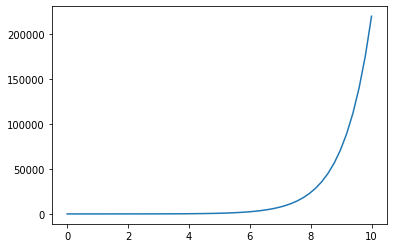

None


<Figure size 432x288 with 0 Axes>

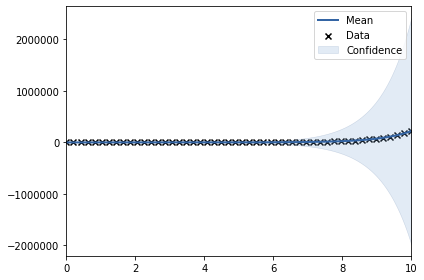

In [105]:
shift = 0
end =10
t1 = np.linspace(0,end, 50).reshape(-1,1)  + shift
# t1 = np.linspace(0,20, 30).reshape(-1,1)


# create simple GP Model
kernel_lfm1 = LFM1(input_dim=1, bvec=np.array([1.0]),
                 lengthscales=np.array([1.0]),
                 Smat=np.array([[1.0]]))


# y1 = np.exp(t1)  * (t1)

# y1 = np.exp(0.1 * t1) * (np.sin(t1) - np.cos(t1)) / (0.1**2 + 1)
b = 30
# y1 = (1.0 / (b**2 +1)) *  (b * np.exp( t1) - np.sin(b * t1) - np.cos(b * t1))
# y1 =  np.exp(t1-0.5)  * erf(t1 / np.sqrt(2))
# y1 = np.exp(2 * t1)
y1 = t1 * np.exp(t1)
plt.plot(t1, y1)
plt.show()


kernel = GPy.kern.RBF(t1.shape[1])

likelihood = GPy.likelihoods.Gaussian(variance=1)

m = GPy.models.GPRegression(t1, y1 , kernel=kernel_lfm1)


optimize = True
plot = True
if optimize:
    m.optimize('bfgs', max_iters=200, messages=True)
if plot:
    print(m.normalizer)
#     m.normalizer = False
    plt.show()
    plt.figure()
    m.plot(plot_limits=(0 + shift,  end+ shift))
    
    plt.show()
    tstar =  np.linspace(0 + shift,end + shift, 100).reshape(-1,1)


    k_train =  m.kern.K(t1,t1)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1dc6b3c9348>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1dc6b619a88>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1dc6aff9dc8>]}

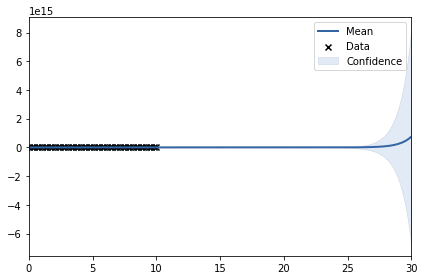

In [107]:
to = np.linspace(0+shift, end+20+shift)
m.plot(plot_limits=(0 + shift, end + 20+ shift))
# plt.plot(to, np.exp(to-0.5)  * erf(to / np.sqrt(2)), 'r')

### Latent Force

In [108]:
from scipy.linalg import pinvh

def latent_force(model, X, q=0):
    Xtrain = np.array(model.X)
    Ytrain = np.array(model.Y)
    Kyf  = model.kern.K_y_f(Xtrain, X, q)
    Kyy = model.kern.K(Xtrain)
    Kyy += np.sqrt(model.likelihood.variance) * np.eye(Kyy.shape[0])
    Kyyinv = pinvh(Kyy)
    
    Kff =  np.squeeze(model.kern.K_ff(X,X, q))
    W =  ((Kyf.T).dot(Kyyinv))
    
    cross_term = W.dot(Kyf)
    
    sigma = Kff - cross_term
    return (W).dot(Ytrain), np.sqrt(np.diag(sigma))

tstar =  np.linspace(0,end, 100).reshape(-1,1)
# mu_pred , sigma_pred =  m.predict(tstar, full_cov=False)
# sigma_pred = np.sqrt(sigma_pred).flatten()

mu_lfm, sigma_lfm = latent_force(m, tstar)
mu_lfm = mu_lfm.flatten()
sigma_lfm = sigma_lfm.flatten()

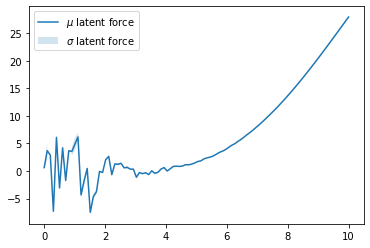

In [109]:


# plt.plot(tstar, mu_pred, label="$\mu$ prediction")
# plt.fill_between(tstar.flatten(), mu_pred.flatten()-2*sigma_pred, mu_pred.flatten()+2*sigma_pred, alpha=.2, label="$\sigma$ prediction")

plt.plot(tstar, mu_lfm, label="$\mu$ latent force")
plt.fill_between(tstar.flatten(), mu_lfm-2*sigma_lfm, mu_lfm+2*sigma_lfm, alpha=.2, label="$\sigma$ latent force")
plt.legend()

In [75]:
lfmold = mu_lfm.copy()

In [85]:
mu_lfm == mu_lfm


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])